# AdaBoost
Boosting (originally called hypothesis boosting) refers to any Ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. There are many boosting methods available, but by far the most popular are AdaBoost13 (short for Adaptive Boosting) and Gradient Boosting.

One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by AdaBoost.

For example, when training an AdaBoost classifier, the algorithm first trains a base classifier (such as a Decision Tree) and uses it to make predictions on the training set. The algorithm then increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.


##### AdaBoost technique follows a decision tree model with a depth equal to one. AdaBoost is nothing but the forest of stumps rather than trees. AdaBoost works by putting more weight on difficult to classify instances and less on those already handled well. AdaBoost algorithm is developed to solve both classification and regression problem. 

Idea behind AdaBoost:

- Stumps (one node and two leaves) are not great in making accurate classification so it is nothing but a week classifier/ weak learner. Combination of many weak classifier makes a strong classifier and this is the principle behind the AdaBoost algorithm.
- Some stumps get more performance or classify better than others.
- Consecutive stump is made by taking the previous stumps mistakes into account.


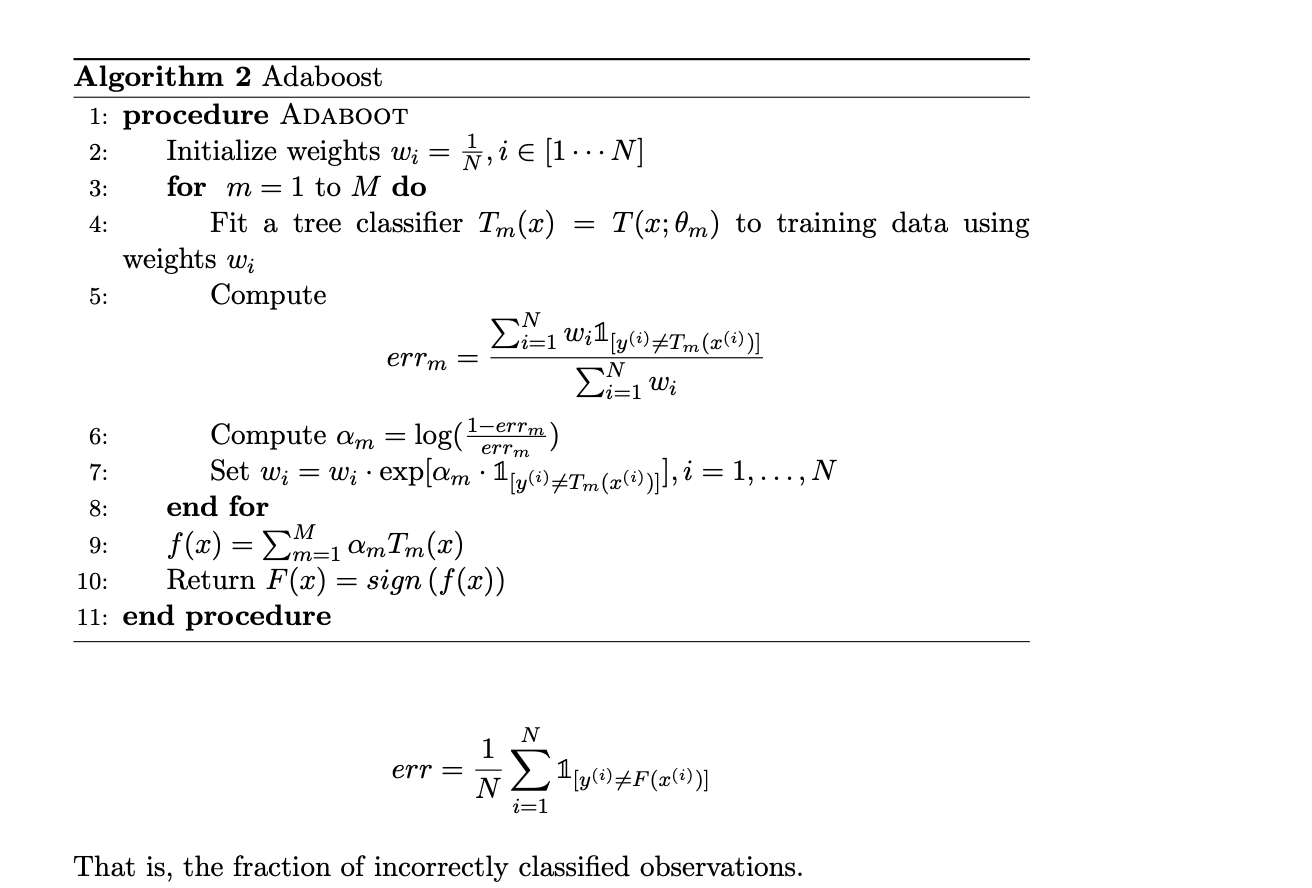

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from sklearn import tree
from dtreeviz.trees import *


## Step 1: Assign Equal Weights to all the observations
 
Initially assign same weights to each record in the dataset.

Sample weight = 1/N

Where N = Number of records

## Step 2: Classify random samples using stumps
 
Draw random samples with replacement from original data with the probabilities equal to the sample weights and fit the model. Here the model (base learners) used in AdaBoost is decision tree. Decision trees are created with one depth which has one node and two leaves also referred to as stumps. Fit the model to the random samples and predict the classes for the original data.

## Step 3: Calculate Total Error
 
Total error is nothing but the sum of weights of misclassified record.

Total Error = Weights of misclassified records

Total error will be always between 0 and 1.

0 represents perfect stump (correct classification)

1 represents weak stump (misclassification)



## Step 4: Calculate Performance of the Stump
 
Using the Total Error, determine the performance of the base learner. The calculated performance of stump(α) value is used to update the weights in consecutive iteration and also used for final prediction calculation.

###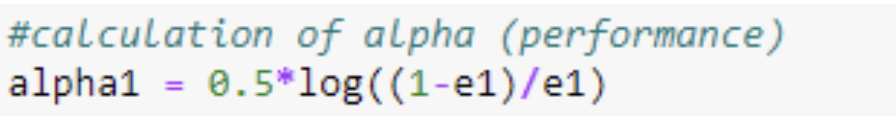 
### Performance of the stump(α) = ½ ln (1 – Total error/Total error)

#### Using the performance parameter(α), we can increase the weights of the wrongly classified records and decrease the weights of the correctly classified records.



### Step 5: Update Weights
 
Based on the performance of the stump(α) update the weights. We need the next stump to correctly classify the misclassified record by increasing the corresponding sample weight and decreasing the sample weights of the correctly classified records.

New weight = Weight * e(performance) → misclassified records

New weight = Weight * e-(performance) → correctly classified records


Here the sum of the updated weights is not equal to 1. whereas in case of initial sample weight the sum of total weights is equal to 1. So, to achieve this we will be dividing it by a number which is nothing but the sum of the updated weights (normalizing constant).

#### Normalizing constant = ∑ New weight

#### Normalized weight = New weight / Normalizing constant

### Step 6: Update weights in iteration
 
Use the normalized weight and make the second stump in the forest. Create a new dataset of same size of the original dataset with repetition based on the newly updated sample weight. So that the misclassified records get higher probability of getting selected. Repeat step 2 to 5 again by updating the weights for a particular number of iterations.



### Step 7: Final Predictions
 
Final prediction is done by obtaining the sign of the weighted sum of final predicted value.

Final prediction/sign (weighted sum) = ∑ (αi* (predicted value at each iteration))

For example: 5 weak classifiers may predict the values 1.0, 1.0, -1.0, 1.0, -1.0. From a majority vote, it looks like the model will predict a value of 1.0 or the first class. These same 5 weak classifiers may have the performance (α) values as 0.2, 0.5, 0.8, 0.2 and 0.9 respectively. Calculating the weighted sum of these predictions results in an output of -0.8, which would be an ensemble prediction of -1.0 or the second class.

Calculation:

t = 1.0*0.2 + 1.0*0.5 - 1.0*0.8 + 1.0*0.2 - 1.0*0.9 = -0.8

Taking the sign alone into consideration, the final prediction will be -1.0 or the second class.



# The Code

In [243]:
def compute_error(y,y_pred, wi):
    """
    Calculate the error rate of a weak classifier m. 
    Params:
        y: np.array - actual target value
        y_pred: np.array- predicted value by weak classifier
        w_i: np.array- individual weights for each observation
    returns: float  
    """
    return (np.sum(wi * np.not_equal(y, y_pred))/sum(wi))
    
    

In [244]:
def compute_aplha(err):
    """
    Calculate the performance of a weak classifier m in the majority vote of the final classifier. 
    Params:
          error: error rate from weak classifier m
    returns: float
    """
    return np.log((1-err)/err)

In [245]:
compute_aplha(0.01)

4.59511985013459

In [246]:
def update_weights(w_i, alpha, y, y_pred):
    """
    Update individual weights w_i after a boosting iteration. 
    Arguments:
        w_i: individual weights for each observation, shape=(n,)
        y: actual target value, shape=(n,)
        y_pred: predicted value by weak classifier, shape=(n,) 
    retrun: 
    """
    exp_alpha = np.exp(alpha * np.not_equal(y, y_pred).astype(int))
    return w_i * exp_alpha 


In [247]:
y = [1,2,1,1,1]
y_pred = [1,0,1,0,1]
np.not_equal(y, y_pred).astype(int)

array([0, 1, 0, 1, 0])

In [251]:
class Adaboost:
    
    def __init__(self):
        self.alphas = []
        self.trees = []
        self.m = None 
        self.errors = []
        self.training_errors = []
        self.prediction_errors = []
        
    def fit(self, X, y, M=100):
        '''
        Fit model. Arguments:
        X: independent variables - array-like matrix
        y: target variable - array-like vector
        M: number of boosting rounds. Default is 100 - integer
        '''
        # Clear before calling
        self.alphas = [] 
        self.training_errors = []
        self.M = M
        
        # Iterate over M weak classifiers
        for m in range(0, M):
            
            # Set weights for current boosting iteration
            if m == 0:
#                 print(0)
                w_i = np.ones(len(y)) * 1 / len(y)  # At m = 0, weights are all the same and equal to 1 / N
#             else:
                
#                 # (d) Update w_i
#                 w_i = update_weights(w_i, alpha, y, y_pred)
            
            # train weak classifiers 
            dt = DecisionTreeClassifier(max_depth=1)
            dt.fit(X,y, sample_weight=w_i)
            y_pred = dt.predict(X)
            self.trees.append(dt) # save to the list of trees 

            
        # 3 calculate total Errors 
            err = compute_error(y,y_pred, w_i)
            self.errors.append(err)
            
        # 4 Calculate Performance of the Stump 
                
            alpha = compute_aplha(err)
            self.alphas.append(alpha)
#                 print(self.alphas)
            # 5 update weights of misclassified 
            w_i = update_weights(w_i, alpha, y, y_pred)
        
        print(self.alphas)
        print(self.errors)
        print(w_i.shape)
#         print(self.trees)
#         return trees 
      
    def predict(self, X):
        '''
        Predict using fitted model. Arguments:
        X: independent variables - array-like
        '''

        # Initialise dataframe with weak predictions for each observation
        weak_preds = pd.DataFrame(index = range(len(X)), columns = range(self.M)) 
        # Predict class label for each weak classifier, weighted by alpha_m
        for m in range(self.M):
            y_pred_m = self.trees[m].predict(X) * self.alphas[m]
            weak_preds.iloc[:,m] = y_pred_m
#             y_pred = np.sum(y_pred, axis=0)
            
        # Calculate final predictions
        y_pred = (1 * np.sign(weak_preds.T.sum())).astype(int)
        return y_pred

In [252]:
# Dataset
from sklearn.datasets import make_classification
X, y = make_classification(n_samples= 1000, n_features = 20, random_state = 42)
y = y * 2 - 1       # Original AdaBoost uses {1, -1} as class labels

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# X_train

In [253]:
# Fit model
from sklearn.metrics import roc_auc_score
ab = Adaboost()
ab.fit(X_train, y_train, M = 20)

# Predict on test set
y_pred = ab.predict(X_test)

print('The ROC-AUC score of the model is:', round(roc_auc_score(y_test, y_pred), 4))

[1.957388036899982, 0.8006037009332694, 0.4075878798091614, 0.26961593016038793, 0.2767940523175256, 0.4515211003051151, 0.4260276051240779, 0.2885696631946503, 0.31840524617153854, 0.37780161051985334, 0.4223569269699736, 0.12300246532831552, 0.13579489229434846, 0.3472201594143127, 0.3191325384937822, 0.14366474793171413, 0.1296688496792638, 0.12176396068573371, 0.11476848699521015, 0.2668158109778378]
[0.12375000000000196, 0.30989639620167586, 0.39949064310787064, 0.4330013860488021, 0.43123993145620476, 0.38899917174795784, 0.3950753006467899, 0.42835407320436575, 0.4210644506694368, 0.40665723110851004, 0.39595289599868944, 0.46928809549317635, 0.4661033494916277, 0.414056687100913, 0.42088716940250626, 0.46414546030698445, 0.4676281332834389, 0.4695965651639176, 0.47133933074407913, 0.4336889751747704]
(800,)
The ROC-AUC score of the model is: 0.8553


##### When do we stop Training Adaboost?
- Enough Iterations 
- no good classifier is left 
- when the error is half(There is no missclassfication) 
- when the error is Zero or one. 
